In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
import pyspark.sql.functions as F

from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix

In [2]:
spark = SparkSession.builder.appName('Fraud Detection').getOrCreate()

In [3]:
spark

In [8]:
filepath = 'data/creditcard.csv'

In [9]:
df = spark.read.csv(filepath, inferSchema=True, header=True)

In [10]:
df.printSchema()

root
 |-- Time: double (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double (nulla

In [11]:
label_column = 'Class'
columns = df.columns
numeric_columns = columns
numeric_columns.remove('Class')

print(f"Label Column: {label_column}")
print(f"Numeric Columns:\n{numeric_columns}")

Label Column: Class
Numeric Columns:
['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [12]:
# looking at the data:
df.toPandas().head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [13]:
df_features = df.select(F.col(label_column).alias('label'), *numeric_columns)

In [15]:
# creating the features:
stages = []
assembler = VectorAssembler(inputCols=numeric_columns, outputCol='features')
stages += [assembler]

In [17]:
# Lets create the normal and anomaly data:

normal = df_features.filter('Class == 0').sample(withReplacement=False, fraction=0.5, seed=2020)
anomaly = df_features.filter('Class == 1')

In [18]:
# Splitting into train and test:

normal_train, normal_test = normal.randomSplit([0.8, 0.2], seed=2020)
anomaly_train, anomaly_test = anomaly.randomSplit([0.8, 0.2], seed=2020)

In [19]:
# Combinging normal and anomaly:

train = normal_train.union(anomaly_train)
test = normal_test.union(anomaly_test)

In [20]:
# Lets create a Pipeline for assembling features vector:

pipeline = Pipeline(stages=stages)
pipeline_model = pipeline.fit(df_features)

train = pipeline_model.transform(train)
test = pipeline_model.transform(test)

selected_cols = ['label', 'features'] + numeric_columns

train = train.select(selected_cols)
test = test.select(selected_cols)

print(f'Training dataset count: {train.count()}')
print(f'Test dataset count: {test.count()}')

Training dataset count: 114389
Test dataset count: 28459


In [21]:
# Model training :

logreg = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
lr_model = logreg.fit(train)

In [23]:
training_summary = lr_model.summary
auc_score = training_summary.areaUnderROC

In [26]:
# Model evaluation:

preds = lr_model.transform(test)

y_true = preds.select(['label']).collect()
y_pred = preds.select(['prediction']).collect()

In [27]:
evaluations = lr_model.evaluate(test)
accuracy = evaluations.accuracy

In [28]:
print(f"AUC Score: {roc_auc_score(y_true, y_pred):.3%}")
print(f"Pyspark AUC Score: {auc_score:.3%}")
print(f"Accuracy: {accuracy:.3%}")

AUC Score: 90.680%
Pyspark AUC Score: 98.271%
Accuracy: 99.909%


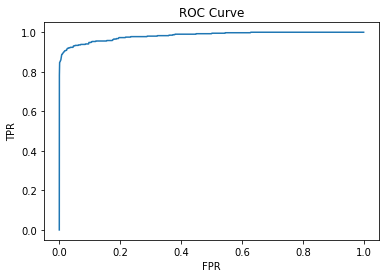

In [30]:
# Lets plot the ROC Curve:

roc_curve = training_summary.roc.toPandas()

plt.figure()
sns.lineplot(data=roc_curve, x='FPR', y='TPR')
plt.title('ROC Curve')
plt.show();

In [32]:
# lets look at the confusion matrix:
conf_matrix = confusion_matrix(y_true, y_pred)

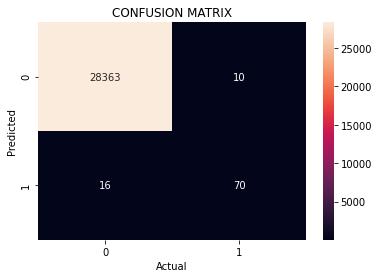

In [34]:
plt.figure()
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('CONFUSION MATRIX')
plt.show();